## Pseudo-labeling Semisupervised Learning

Because I am only able to confidently label a small portion of the larger Bexar property dataset, pseudo-labeling can be a way to train a model on the larger dataset. First I train a series of models on the small, labeled data. Then I use that trained model to label the far-larger unlabeled dataset. Lastly, I can then train a new model on a dataset containing both the original, labeled data and the new, pseudo-labeled data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.simplefilter('ignore')
from joblib import dump, load

from sklearn.svm import SVC
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer, f1_score

#### Load Data and Separate Labeled and Unlabeled Dataframes

In [2]:
# Read in data
labeled_df = pd.read_hdf('../data/processed/bexar_true_labels.h5')
all_df = pd.read_hdf('../data/processed/bexar_processed.h5')

In [3]:
# Trim to just the data needed for modeling
all_df['price_psf'] = all_df['price_psf'].fillna(0)
# Trim outlier properties
trim_prop_df = all_df[(all_df.price_psf<all_df.price_psf.quantile(.999))]

nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()
variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value',
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

# Drop columns
sub_df = trim_prop_df[variables_list]
sub_df = sub_df.dropna()

In [4]:
# Grab only properties not already in the labeled dataset
unlabeled_df = sub_df[~(sub_df['prop_id'].isin(labeled_df.prop_id))]

X_labeled = labeled_df.iloc[:,1:-1]
y_labeled = labeled_df.crim_prop
X_unlabeled = unlabeled_df.iloc[:,1:-1]

In [5]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.33, random_state=13
)

In [6]:
# List of models to try
models = [
    SVC(),
    XGBClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

for model in models:
    print(type(model).__name__,'\n')
    model.seed = 42
    num_folds = 5

    scores = cross_val_score(model, X_train, y_train, cv=num_folds)
    
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    print('Conf matrix for training data:')
    print(confusion_matrix(y_train,y_pred_train,labels=[1,0]))
    print('Recall is',recall_score(y_train,y_pred_train))
    print('Precision is',precision_score(y_train,y_pred_train))
    print('F1 Score:',f1_score(y_train,y_pred_train,zero_division=1),'\n')
    print("CV scores:",scores,'\n')
    
    y_pred = model.predict(X_test)
    print('Conf matrix for test data:')
    print(confusion_matrix(y_test,y_pred,labels=[1,0]))
    print('Recall is',recall_score(y_test,y_pred))
    print('Precision is',precision_score(y_test,y_pred,zero_division=1))
    print('F1 Score:',f1_score(y_test,y_pred,zero_division=1),'\n'*2,'*'*40,'\n')

SVC 

Conf matrix for training data:
[[   0   32]
 [   0 3695]]
Recall is 0.0
Precision is 0.0
F1 Score: 0.0 

CV scores: [0.99061662 0.99061662 0.99194631 0.99194631 0.99194631] 

Conf matrix for test data:
[[   0   15]
 [   0 1821]]
Recall is 0.0
Precision is 1.0
F1 Score: 0.0 

 **************************************** 

XGBClassifier 

Conf matrix for training data:
[[  32    0]
 [   0 3695]]
Recall is 1.0
Precision is 1.0
F1 Score: 1.0 

CV scores: [0.99463807 0.99731903 0.99731544 0.99463087 0.99328859] 

Conf matrix for test data:
[[  10    5]
 [   1 1820]]
Recall is 0.6666666666666666
Precision is 0.9090909090909091
F1 Score: 0.7692307692307692 

 **************************************** 

RandomForestClassifier 

Conf matrix for training data:
[[  32    0]
 [   0 3695]]
Recall is 1.0
Precision is 1.0
F1 Score: 1.0 

CV scores: [0.99329759 0.99865952 0.99597315 0.99597315 0.99194631] 

Conf matrix for test data:
[[   6    9]
 [   4 1817]]
Recall is 0.4
Precision is 0.6
F1 Score

Gradient Boosting with default parameters appears to be the most robust, so I will use that for pseudo-labeling.

In [7]:
# Grid-search Gradient Boosting model for pseudo-labeling
scoring = {
    'AUC': 'roc_auc',
    'Recall': make_scorer(recall_score,pos_label=1),
    'Precision': make_scorer(precision_score,pos_label=1)
}
gs = GradientBoostingClassifier(random_state=42)
grid = {
    'max_depth': [2,3,4],
    'n_estimators': [75,100],
    'max_features': ['auto','sqrt']
}
gbc_gs = GridSearchCV(gs, grid, cv=3, scoring=scoring, refit='Recall')

# Train on original training data
gbc_gs.fit(X_train,y_train)
print('Model gridsearched and trained'+'\n')

# Performance
y_pred_train = gbc_gs.predict(X_train)
print('Conf matrix for training data:')
print(confusion_matrix(y_train,y_pred_train,labels=[1,0]))
print('Recall is',recall_score(y_train,y_pred_train))
print('Precision is',precision_score(y_train,y_pred_train))
print('F1 Score:',f1_score(y_train,y_pred_train,zero_division=1),'\n')
print("CV scores:",scores,'\n')

y_pred = gbc_gs.predict(X_test)
print('Conf matrix for test data:')
print(confusion_matrix(y_test,y_pred,labels=[1,0]))
print('Recall is',recall_score(y_test,y_pred))
print('Precision is',precision_score(y_test,y_pred,zero_division=1))
print('F1 Score:',f1_score(y_test,y_pred,zero_division=1),'\n')

Model gridsearched and trained

Conf matrix for training data:
[[  32    0]
 [   0 3695]]
Recall is 1.0
Precision is 1.0
F1 Score: 1.0 

CV scores: [0.99463807 0.99731903 0.99731544 0.99463087 0.99463087] 

Conf matrix for test data:
[[  10    5]
 [   5 1816]]
Recall is 0.6666666666666666
Precision is 0.6666666666666666
F1 Score: 0.6666666666666666 



In [8]:
# Predict pseudo-labels on unlabeled data
pseudo_labels = gbc_gs.predict(X_unlabeled)

# Add pseudo-labels
augmented = X_unlabeled.copy(deep=True)
augmented['crim_prop'] = pseudo_labels

In [9]:
# Take a fraction of the pseudo-labeled data to combine with the labeled training data
sample_aug = augmented.sample(frac=.15,random_state=42)
print('Length of pseudo-labeled data:',len(sample_aug))

Length of pseudo-labeled data: 86708


In [10]:
# Re-merge
temp_labeled = pd.concat([X_labeled,y_labeled],axis=1)
# Concat labeled data with pseudo-labeled data
augmented_labeled = pd.concat([sample_aug,temp_labeled])

In [11]:
X_aug = augmented_labeled.iloc[:,:-1]
y_aug = augmented_labeled.crim_prop

In [12]:
# scoring = {
#     'AUC': 'roc_auc',
#     'Recall': make_scorer(recall_score,pos_label=1),
#     'Precision': make_scorer(precision_score,pos_label=1)
# }
# gs = GradientBoostingClassifier(random_state=42)
# grid = {
#     'max_depth': [2,3,4],
#     'n_estimators': [75,100],
#     'max_features': ['auto','sqrt']
# }

# gbc_gs_pseudo = GridSearchCV(gs, grid, cv=3, scoring=scoring, refit='Recall')

# gbc_gs_pseudo.fit(X_aug, y_aug)
# print('Model gridsearched and trained')

In [13]:
# Load the model
gbc_gs_pseudo = load('../models/gbc_gs_pseudo.joblib')

In [14]:
print('Best parameters:',gbc_gs_pseudo.best_params_)

Best parameters: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}


In [15]:
print('original GBC performance')
y_pred_test = gbc_gs.predict(X_test)

# Evaluate performance of original model
print(confusion_matrix(y_test,y_pred_test,labels=[1,0]))

gbc_gs_recall = recall_score(y_test,y_pred_test)
gbc_gs_precision = precision_score(y_test,y_pred_test)
gbc_gs_f1 = f1_score(y_test,y_pred_test)

print('Recall:',gbc_gs_recall)
print('Precision:',gbc_gs_precision)
print('F1 Score:',gbc_gs_f1)

print('\n'+'pseudo GBC performance')
y_pred_test_pseudo = gbc_gs_pseudo.predict(X_test)

gbc_pseudo_recall = recall_score(y_test,y_pred_test_pseudo)
gbc_pseudo_precision = precision_score(y_test,y_pred_test_pseudo)
gbc_pseudo_f1 = f1_score(y_test,y_pred_test_pseudo)

# Evaluate performance of model trained on pseudo-data and original data
print(confusion_matrix(y_test,y_pred_test_pseudo,labels=[1,0]))
print('Recall:',gbc_pseudo_recall)
print('Precision:',gbc_pseudo_precision)
print('F1 Score:',gbc_pseudo_f1)

original GBC performance
[[  10    5]
 [   5 1816]]
Recall: 0.6666666666666666
Precision: 0.6666666666666666
F1 Score: 0.6666666666666666

pseudo GBC performance
[[  12    3]
 [   3 1818]]
Recall: 0.8
Precision: 0.8
F1 Score: 0.8000000000000002


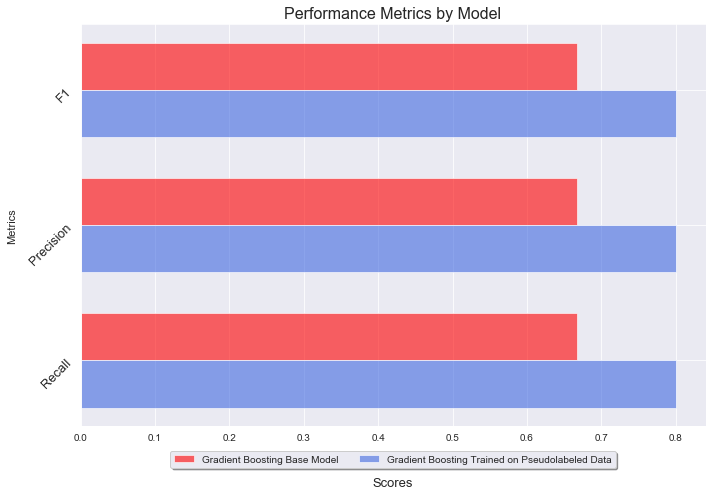

In [16]:
n_groups = 3
base_scores = [gbc_gs_recall, gbc_gs_precision, gbc_gs_f1]
pseudo_scores = [gbc_pseudo_recall, gbc_pseudo_precision, gbc_pseudo_f1]

# create plot
# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = plt.barh(
    index + bar_width, 
    base_scores,
    bar_width,
    alpha=opacity,
    color='red',
    label='Gradient Boosting Base Model'
)

rects2 = plt.barh(
    index, 
    pseudo_scores, 
    bar_width,
    alpha=opacity,
    color='royalblue',
    label='Gradient Boosting Trained on Pseudolabeled Data'
)

plt.ylabel('Metrics',fontsize=11,labelpad=10)
plt.xlabel('Scores',fontsize=13,labelpad=35)
plt.title('Performance Metrics by Model',fontsize=16)
plt.yticks(index + bar_width/2, ('Recall', 'Precision', 'F1'),fontsize=13,rotation=45)

# plt.legend()

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.tight_layout()
# plt.savefig('../data/figures/model_performance_metrics.png')
plt.show()

In [17]:
# Save the model
# dump(gbc_gs_pseudo, '../models/gbc_gs_pseudo.joblib')

#### Feature Importance

In [18]:
# Grab features, sort by index
gbc_gs_pseudo.best_estimator_.feature_importances_[:10]

feature_importance = gbc_gs_pseudo.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
features = X_aug.columns

In [19]:
np.argsort(feature_importance)

array([ 0,  1,  2,  3, 24, 22,  6, 21, 16, 19, 10, 13, 14, 18, 20, 26, 27,
        4, 17,  8,  5, 23, 12, 25,  7, 15, 11,  9])

In [20]:
feature_importance

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.22909419e-03, 4.45983430e-02, 0.00000000e+00, 6.09382701e-02,
       2.56657482e-02, 3.15161621e-01, 6.22510235e-05, 2.24533272e-01,
       4.68295218e-02, 6.52364761e-05, 2.42838098e-04, 1.42125115e-01,
       0.00000000e+00, 1.06955788e-02, 9.27129581e-04, 2.74437010e-05,
       4.56480831e-03, 0.00000000e+00, 0.00000000e+00, 4.48613795e-02,
       0.00000000e+00, 5.77556064e-02, 5.67887599e-03, 7.03786610e-03])

In [21]:
feature_importance[sorted_idx][-10:]

array([0.01069558, 0.02566575, 0.04459834, 0.04486138, 0.04682952,
       0.05775561, 0.06093827, 0.14212512, 0.22453327, 0.31516162])

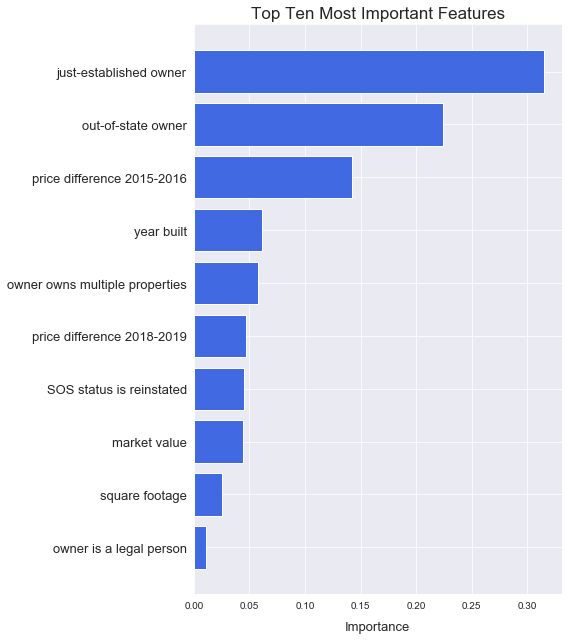

In [23]:
# Plot
plt.figure(figsize=(8,9))
pos = np.arange(sorted_idx[-10:].shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][-10:],color='royalblue')
readable_feats = [
    'owner is a legal person',
    'square footage',
    'market value',
    'SOS status is reinstated',
    'price difference 2018-2019',
    'owner owns multiple properties',
    'year built',
    'price difference 2015-2016',
    'out-of-state owner',
    'just-established owner'
]

plt.yticks(pos, readable_feats,fontsize=13)
plt.xlabel('Importance',labelpad=10,fontsize=13)
plt.title('Top Ten Most Important Features',fontsize=17)
plt.savefig('../data/figures/gbc_variable_importance_top_ten.png')
plt.tight_layout()
plt.show()

#### Final Notes

- Every model struggles to adapt from the training data to the test data.
- Gradient Boosting appears to be the most robust.
- Using pseudolabels from 15% of the unlabeled data creates a good Gradient Boosting model that performs well in precision, recall, and f1 score.